<a href="https://www.kaggle.com/code/loyunsheng/alexnet-on-tensorflow-sgd?scriptVersionId=193337336" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import tensorflow as tf
import numpy as nps
from tensorflow import keras
from tensorflow.keras import layers
from keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import torch
import torch.optim as optim
from sklearn.model_selection import train_test_split
from tensorflow.keras import callbacks
import pandas as pd
import os

2024-08-20 16:27:22.593878: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-20 16:27:22.593986: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-20 16:27:22.732344: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
# check CUDA
CUDA = torch.cuda.is_available()

device = torch.device('cuda' if CUDA else 'cpu')
print(device)

cuda


# Download the Dataset to the Working Space

In [3]:
!cp -r /kaggle/input/dogs-cats-images /kaggle/working/

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


# AlexNet

In [4]:
def AlexNet():
    model = Sequential([
      # Convolution 1 with MaxPooling
      layers.Conv2D(input_shape=(227, 227 ,3), filters=96, kernel_size=(11, 11), strides=(4, 4)),
      layers.Activation('relu'),
      layers.BatchNormalization(),
      layers.MaxPool2D(pool_size=(3, 3), strides=(2, 2)),
        
      # Convolution 2 with MaxPooling
      layers.ZeroPadding2D(padding=(2, 2)),
      layers.Conv2D(filters=256, kernel_size=(5, 5), strides=(3, 3)),
      layers.Activation('relu'),
      layers.BatchNormalization(),
      layers.MaxPool2D(pool_size=(3, 3), strides=(2, 2)),
        
      # Convolution 3
      layers.ZeroPadding2D(padding=(1, 1)),
      layers.Conv2D(filters=384, kernel_size=(3, 3)),
      layers.Activation('relu'),
        
      # Convolution 4
      layers.ZeroPadding2D(padding=(1, 1)),
      layers.Conv2D(filters=384, kernel_size=(3, 3)),
      layers.Activation('relu'),
        
      # Convolution 5
      layers.ZeroPadding2D(padding=(1, 1)),
      layers.Conv2D(filters=256, kernel_size=(3, 3)),
      layers.Activation('relu'),
      layers.BatchNormalization(),
      layers.MaxPool2D(pool_size=(3, 3), strides=(2, 2)),
      
      # Flatten the output from the convolutional layers to a 1D feature vector
      layers.Flatten(),

      # Fully-Connected 
      layers.Dense(4096, activation='relu', input_shape=6*6*128*2),
      layers.Dropout(0.5),
      layers.Dense(4096, activation='relu'),
      layers.Dropout(0.5),
      layers.Dense(2, activation='softmax'),
 ])
    
    # Add dynamic lr
    lr_schedule = keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=1e-3,
        decay_steps=1000,
        decay_rate=0.9)
    
    # check the architecture
    model.summary()
    
    model.compile(optimizer=keras.optimizers.SGD(momentum=0.9, weight_decay=0.0005, learning_rate=lr_schedule), loss=keras.losses.CategoricalCrossentropy(), metrics=['accuracy'])

    return model

# Data Preprocesssing

In [5]:
train_dataset_path = '/kaggle/working/dogs-cats-images/dataset/training_set'
valid_dataset_path = '/kaggle/working/dogs-cats-images/dataset/test_set'


train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    shear_range=0.2,
    horizontal_flip=True,
    featurewise_std_normalization=True,
    samplewise_std_normalization=True,
)

validate_datagen = ImageDataGenerator(
    rescale=1./255,
    featurewise_std_normalization=True,
    samplewise_std_normalization=True,
)

train_generator = train_datagen.flow_from_directory(
    train_dataset_path,
    target_size=(227, 227),
    batch_size=128,
    shuffle=True,
    class_mode='categorical',
)

valid_datagenerator = validate_datagen.flow_from_directory(
    valid_dataset_path,
    target_size=(227, 227),
    batch_size=128,
    shuffle=False,
    class_mode='categorical',

)

/opt/conda/lib/python3.10/site-packages/keras/src/legacy/preprocessing/image.py:1063: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, which overrides setting of `featurewise_center`.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/keras/src/legacy/preprocessing/image.py:1072: UserWarning: This ImageDataGenerator specifies `samplewise_std_normalization`, which overrides setting of `samplewise_center`.
  warnings.warn(


Found 8000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


# Training

In [6]:
model = AlexNet()

with tf.device('/GPU:0'):
    model_train = model.fit(
        train_generator,
        epochs=50,
        validation_data=valid_datagenerator
    )

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 55, 55, 96)     │        34,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 55, 55, 96)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 55, 55, 96)     │           384 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 27, 27, 96)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ zero_padding2d (ZeroPadding2D)  │ (None, 31, 31, 96)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 9, 9, 256)      │       614,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 9, 9, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 9, 9, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ zero_padding2d_1                │ (None, 6, 6, 256)      │             0 │
│ (ZeroPadding2D)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 4, 4, 384)      │       885,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 4, 4, 384)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ zero_padding2d_2                │ (None, 6, 6, 384)      │             0 │
│ (ZeroPadding2D)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 4, 4, 384)      │     1,327,488 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 4, 4, 384)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ zero_padding2d_3                │ (None, 6, 6, 384)      │             0 │
│ (ZeroPadding2D)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 4, 4, 256)      │       884,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 4, 4, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 1, 1, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4096)           │     1,052,67

 Total params: 21,591,810 (82.37 MB)

 Trainable params: 21,590,594 (82.36 MB)

 Non-trainable params: 1,216 (4.75 KB)

/opt/conda/lib/python3.10/site-packages/keras/src/legacy/preprocessing/image.py:1263: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/keras/src/legacy/preprocessing/image.py:1273: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn(


Epoch 1/50


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


 2/63 ━━━━━━━━━━━━━━━━━━━━ 3s 64ms/step - accuracy: 0.4570 - loss: 0.9378  

I0000 00:00:1724171395.429549      81 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1724171395.455612      81 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


25/63 ━━━━━━━━━━━━━━━━━━━━ 1:12 2s/step - accuracy: 0.5030 - loss: 0.8514

W0000 00:00:1724171440.999096      84 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5402 - loss: 0.8011

W0000 00:00:1724171499.990627      84 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


63/63 ━━━━━━━━━━━━━━━━━━━━ 140s 2s/step - accuracy: 0.5409 - loss: 0.8002 - val_accuracy: 0.5415 - val_loss: 0.6749
Epoch 2/50


W0000 00:00:1724171506.534360      81 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


63/63 ━━━━━━━━━━━━━━━━━━━━ 121s 2s/step - accuracy: 0.6500 - loss: 0.6452 - val_accuracy: 0.6955 - val_loss: 0.6506
Epoch 3/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 120s 2s/step - accuracy: 0.7000 - loss: 0.5843 - val_accuracy: 0.7140 - val_loss: 0.6111
Epoch 4/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 120s 2s/step - accuracy: 0.7441 - loss: 0.5289 - val_accuracy: 0.7450 - val_loss: 0.5487
Epoch 5/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 120s 2s/step - accuracy: 0.7597 - loss: 0.5018 - val_accuracy: 0.7750 - val_loss: 0.5004
Epoch 6/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 119s 2s/step - accuracy: 0.7795 - loss: 0.4690 - val_accuracy: 0.7710 - val_loss: 0.4739
Epoch 7/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 119s 2s/step - accuracy: 0.7809 - loss: 0.4535 - val_accuracy: 0.7460 - val_loss: 0.5138
Epoch 8/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 118s 2s/step - accuracy: 0.7917 - loss: 0.4478 - val_accuracy: 0.6965 - val_loss: 0.6209
Epoch 9/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 121s 2s/step - accuracy: 0.8062 - loss: 0.4263 - val_accuracy: 0.7280 - val_loss: 0.

# Plot the Results

Minimum Validation Loss: 0.3316


<Axes: title={'center': 'Accuracy'}>

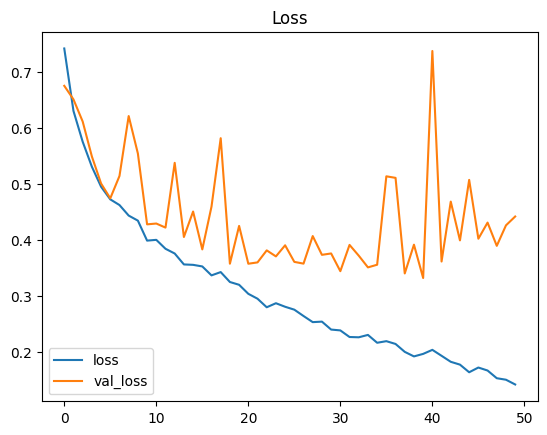

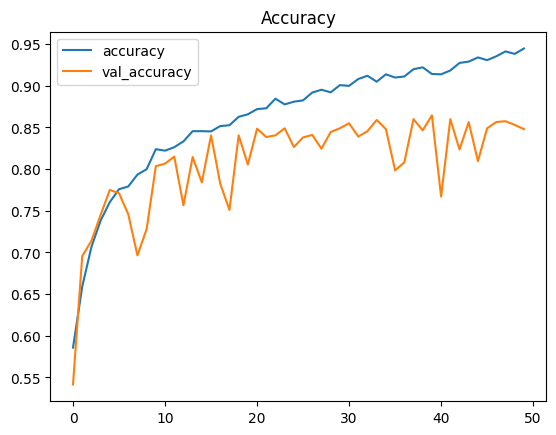

In [7]:
model_train_df = pd.DataFrame(model_train.history)

print("Minimum Validation Loss: {:0.4f}".format(model_train_df['val_loss'].min()))

model_train_df.loc[:, ['loss', 'val_loss']].plot(title='Loss')
model_train_df.loc[:, ['accuracy', 'val_accuracy']].plot(title='Accuracy')

## Reference
1. https://proceedings.neurips.cc/paper_files/paper/2012/file/c399862d3b9d6b76c8436e924a68c45b-Paper.pdf
2. https://martin12345m.medium.com/alexnet%E5%B0%8F%E7%B0%A1%E4%BB%8B-1-%E8%AB%96%E6%96%87%E7%BF%BB%E8%AD%AF-%E4%B8%8A-d4d18c923b08
3. https://medium.com/ching-i/%E5%8D%B7%E7%A9%8D%E7%A5%9E%E7%B6%93%E7%B6%B2%E7%B5%A1-cnn-%E7%B6%93%E5%85%B8%E6%A8%A1%E5%9E%8B-lenet-alexnet-vgg-nin-with-pytorch-code-84462d6cf60c
4. https://github.com/chingi071/Pytorch_note/blob/master/AlexNet.ipynb
5. https://github.com/Insignite/Alexnet-DogvsCat-Classification/tree/master
6. https://www.tensorflow.org/?hl=zh-tw